# Face Mask Detector (UsingTensorFlow + Keras)


### Steps to run if running in `Google Colab`

Specify `TensorFlow` Version to use

In [2]:
%tensorflow_version 1.x

### Download The Dataset and Extract it

In [3]:
import os

dataset_archive_filename = './dataset.zip'
dataset_archive_file_url = 'https://github.com/karim-aly/CppNd-Capstone-Face-Mask-Detector/blob/master/face_mask_detector_model/dataset.zip?raw=true'

dataset_folder_name = './dataset'

In [4]:
if not os.path.exists(dataset_archive_filename):
    !wget -O {dataset_archive_filename} {dataset_archive_file_url}
else:
    print('Dataset is already downloaded earlier !')

--2020-07-24 14:19:45--  https://github.com/karim-aly/CppNd-Capstone-Face-Mask-Detector/blob/master/face_mask_detector_model/dataset.zip?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/karim-aly/CppNd-Capstone-Face-Mask-Detector/raw/master/face_mask_detector_model/dataset.zip [following]
--2020-07-24 14:19:46--  https://github.com/karim-aly/CppNd-Capstone-Face-Mask-Detector/raw/master/face_mask_detector_model/dataset.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/karim-aly/CppNd-Capstone-Face-Mask-Detector/master/face_mask_detector_model/dataset.zip [following]
--2020-07-24 14:19:46--  https://raw.githubusercontent.com/karim-aly/CppNd-Capstone-Face-Mask-Detector/master/face_mask_detector_model/dataset.zip
Resolving raw.githubusercon

In [5]:
if not os.path.exists(dataset_folder_name):
    !unzip {dataset_archive_filename}
else:
    print('Dataset is already extracted !')

Archive:  ./dataset.zip
   creating: dataset/
   creating: dataset/with_mask/
  inflating: dataset/with_mask/0-with-mask.jpg  
  inflating: dataset/with_mask/1-with-mask.jpg  
  inflating: dataset/with_mask/10-with-mask.jpg  
  inflating: dataset/with_mask/100-with-mask.jpg  
  inflating: dataset/with_mask/101-with-mask.jpg  
  inflating: dataset/with_mask/103-with-mask.jpg  
  inflating: dataset/with_mask/104-with-mask.jpg  
  inflating: dataset/with_mask/105-with-mask.jpg  
  inflating: dataset/with_mask/106-with-mask.jpg  
  inflating: dataset/with_mask/107-with-mask.jpg  
  inflating: dataset/with_mask/108-with-mask.jpg  
  inflating: dataset/with_mask/109-with-mask.jpg  
  inflating: dataset/with_mask/11-with-mask.jpg  
  inflating: dataset/with_mask/110-with-mask.jpg  
  inflating: dataset/with_mask/111-with-mask.jpg  
  inflating: dataset/with_mask/112-with-mask.jpg  
  inflating: dataset/with_mask/113-with-mask.jpg  
  inflating: dataset/with_mask/114-with-mask.jpg  
  inflatin

### Import the necessary packages

In [6]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

### Define Functions to make the following:
1. Load and Preprocess The Dataset
2. Build Model
3. Train Model
4. Save Model

In [7]:

def load_dataset(dataset_folder_path):
    # grab the list of images in our dataset directory, then initialize
    # the list of data (i.e., images) and class images
    print("[INFO] loading images...")
    return list(paths.list_images(dataset_folder_path))


def preprocess_dataset(imagePaths):
    data = []
    labels = []

    # loop over the image paths
    for imagePath in imagePaths:
        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]

        # load the input image (224x224) and preprocess it
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        # update the data and labels lists, respectively
        data.append(image)
        labels.append(label)

    return data, labels


def split_dataset_to_train_set_and_test_set(data, labels):
    # convert the data and labels to NumPy arrays
    data = np.array(data, dtype="float32")
    labels = np.array(labels)

    # perform one-hot encoding on the labels
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    labels = to_categorical(labels)

    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    return train_test_split(data, labels,
        test_size=0.20, stratify=labels, random_state=42), lb.classes_


def build_model():
    # load the MobileNetV2 network, ensuring the head FC layer sets are left off
    baseModel = MobileNetV2(weights="imagenet", include_top=False,
        input_tensor=Input(shape=(224, 224, 3), name='face_model/input_node'))

    # construct the head of the model that will be placed on top of the the base model
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(2, activation="softmax", name='face_model/output_node')(headModel)

    # place the head FC model on top of the base model
    # (this will become the actual model we will train)
    model = Model(inputs=baseModel.input, outputs=headModel)

    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable = False

    return model


def get_input_augmentator():
    # construct the training image generator for data augmentation
    return ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")


def train_model(model, trainX, trainY, testX, testY, batch_size=32, epochs=5, initial_lr=1e-4):
    # compile our model
    print("[INFO] compiling model...")
    opt = Adam(lr=initial_lr, decay=initial_lr/epochs)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

    # get the input augmentation feeder
    with tf.device("cpu:0"):
        aug = get_input_augmentator()

    # train the head of the network
    print("[INFO] training head...")
    return model.fit(
        aug.flow(trainX, trainY, batch_size=batch_size),
        steps_per_epoch=len(trainX) // batch_size,
        validation_data=(testX, testY),
        validation_steps=len(testX) // batch_size,
        epochs=epochs)


def evaluate_model(model, testX, testY, classes, batch_size=32):
    # make predictions on the testing set
    print("[INFO] evaluating network...")
    predIdxs = model.predict(testX, batch_size=batch_size)

    # for each image in the testing set we need to find the index of the
    # label with corresponding largest predicted probability
    predIdxs = np.argmax(predIdxs, axis=1)

    # show a nicely formatted classification report
    print(classification_report(testY.argmax(axis=1), predIdxs, target_names=classes))


def save_model_to_disk(model, model_save_dir, model_save_name, save_format_h5=True, save_format_tf=True, save_weights=True):
    # serialize the model to disk (save_format='h5' or 'tf')
    print("[INFO] saving mask detector model...")
    
    # check if model_save_dir exists and if not create it
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    
    if save_format_h5:
        model.save(os.path.join(model_save_dir, model_save_name+'.h5'), save_format='h5')
        
    if save_format_tf:
        model.save(os.path.join(model_save_dir, model_save_name), save_format='tf')
    
    # Save the weights
    if save_weights:
        model.save_weights(os.path.join(model_save_dir, 'checkpoints', model_save_name))

    # save_path = os.path.join(model_save_dir, model_save_name, '1/')
    # tf.saved_model.save(model, save_path)

    from tensorflow.keras import backend as K
    all_saver = tf.train.Saver()
    all_saver.save(K.get_session(), os.path.join(model_save_dir, 'saver_data', model_save_name))
    tf.io.write_graph(K.get_session().graph, model_save_dir, model_save_name+'.pbtxt', as_text=True)


def save_model_loss_and_accuracy_graphs(H, graph_filename, epochs):
    # plot the training loss and accuracy
    if tf.__version__.split('.')[0] == '2':
        accuracy_key = 'accuracy'
        val_accuracy_key = 'val_accuracy'
    else:
        accuracy_key = 'acc'
        val_accuracy_key = 'val_acc'

    N = epochs
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history[accuracy_key], label="train_acc")
    plt.plot(np.arange(0, N), H.history[val_accuracy_key], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(graph_filename)


## Define Main Function

In [8]:
def main(dataset, model_save_dir, model_save_name, model_eval_graph_name, train_on_cpu):
    # Force Use CPU
    if train_on_cpu:
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
    else:
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.gpu_options.per_process_gpu_memory_fraction = 0.95
        tf.keras.backend.set_session(tf.Session(config=config));

    # grab the list of images in our dataset directory
    imagePaths = load_dataset(dataset)

    # pre-process dataset and extract the class label from the filename
    data, labels = preprocess_dataset(imagePaths)

    # partition the data into training and testing splits and perform one-hot encoding on the labels
    (trainX, testX, trainY, testY), classes = split_dataset_to_train_set_and_test_set(data, labels)

    # choose device to use for execution
    device_name = "cpu:0" if train_on_cpu else "gpu:0"
    with tf.device(device_name):
        # build model
        model = build_model()

        # train model
        H = train_model(model, trainX, trainY, testX, testY, batch_size=BS, epochs=EPOCHS, initial_lr=INIT_LR)

        # evaluate model
        evaluate_model(model, testX, testY, classes, batch_size=BS)

    # save model
    save_model_to_disk(model, model_save_dir, model_save_name)

    # save graph
    save_model_loss_and_accuracy_graphs(H, model_eval_graph_name, epochs=EPOCHS)
    
    return model, H

### Define Hyperparamters

In [9]:
# Model Hyper Parameters
# initialize the initial learning rate, number of epochs to train for and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

### Train Model

[INFO] loading images...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 2s 0us/step
[INFO] compiling model...
[INFO] training head...
Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
34/34 [==============================] - 19s 560ms/step - loss: 0.6447 - acc: 0.6498 - val_loss: 0.3533 - val_acc: 0.8877
Epoch 2/20
34/34 [==============================] - 13s 379ms/step - loss: 0.3810 - acc: 0.8474 - val_loss: 0.2305 - val_acc: 0.9384
Epoch 3/20
34/34 [==============================] - 13s 382ms/step - loss: 0.3015 - acc: 0.8811 - val_loss: 0.1951 - val_acc: 0.9275
Epoch 4/20
34/34 [==============================] - 13s 375ms/step - loss: 0.2480 - acc: 0.9073 - val_loss: 0.2079 - val_acc: 0.8986
Epoch 5/20
34/34 [==============================] - 13s 382ms/step - loss: 0.2055 - acc: 0.9129 - val_loss: 0.1031 - val_acc: 0.9783
Epoch 6/20
34/34 [==============================] - 13s 378ms/step - loss: 0.1660 - acc: 0.9522 - val_loss: 0.0874 - val_acc: 0.

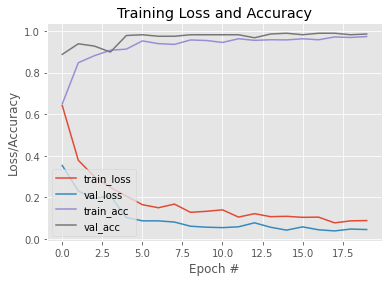

In [10]:
model_save_dir  = './face_mask_detector'
model_save_name = 'face_mask_detector_model'

model, H = main(dataset='./dataset', 
                model_save_dir=model_save_dir, 
                model_save_name=model_save_name, 
                model_eval_graph_name='face_mask_detector_train_graph.png', 
                train_on_cpu=False)

### Check if model still needs some training

In [ ]:
# grab the list of images in our dataset directory
imagePaths = load_dataset('./dataset')

# pre-process dataset and extract the class label from the filename
data, labels = preprocess_dataset(imagePaths)

# partition the data into training and testing splits and perform one-hot encoding on the labels
(trainX, testX, trainY, testY), classes = split_dataset_to_train_set_and_test_set(data, labels)

In [ ]:
aug = get_input_augmentator()

In [ ]:
batch_size = BS
H = model.fit(
        aug.flow(trainX, trainY, batch_size=batch_size),
        steps_per_epoch=len(trainX) // batch_size,
        validation_data=(testX, testY),
        validation_steps=len(testX) // batch_size,
        epochs=1)

evaluate_model(model, testX, testY, classes, batch_size=BS)

# Save and Freeze Model using TensorFlow `Saved Model` format (`tf`)

##### Uncomment and  Run This Cell Only if No Model Saving was made earlier !!

In [ ]:
# model_save_dir  = './face_mask_detector'
# model_save_name = 'face_mask_detector_model'
# model_save_path = os.path.join(model_save_dir, model_save_name)

# save_model_to_disk(model, model_save_dir, model_save_name, save_format_tf=True) # Aleady Saved Earlier

Print `Model Inputs`

In [11]:
print(model.inputs)
print('model.input.op.name = %s' % model.input.op.name)

[<tf.Tensor 'face_model/input_node:0' shape=(?, 224, 224, 3) dtype=float32>]
model.input.op.name = face_model/input_node


Print `Model Outputs`

In [12]:
print(model.outputs)
print('model.output.op.name = %s' % model.output.op.name)

[<tf.Tensor 'face_model/output_node/Softmax:0' shape=(?, 2) dtype=float32>]
model.output.op.name = face_model/output_node/Softmax


#### Use `saved_model_cli` command to check the saved output node name

In [13]:
model_save_path = os.path.join(model_save_dir, model_save_name)

In [14]:
!saved_model_cli show --dir {model_save_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['face_model/input_node'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_face_model/input_node:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['face_model/output_node'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 2)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Defin

So we can figure out from `saved_model_cli` output that the output node name is now `StatefulPartitionedCall:0` and the input node name is now `serving_default_input_1:0`

##### Construct the needed files and folders paths 

In [15]:
import os
import sys

def create_dir_if_not_exists(_dir):
    if not os.path.exists(_dir):
        os.makedirs(_dir)

output_graphs_dir = os.path.join(model_save_dir, 'optimized_graphs')

# check that the output dir exists
create_dir_if_not_exists(output_graphs_dir)

# user input parameters
GRAPH_BINARY = False
INPUT_NAME = 'serving_default_face_model/input_node' #'input_1'
OUTPUT_NAME = 'StatefulPartitionedCall' #'dense_1/Softmax'

# construct the needed files and folders paths 
graph_ext = '.pb' if GRAPH_BINARY else '.pbtxt'

saved_model_default_graph_name = 'saved_model'+graph_ext
saved_model_default_checkpoint_name = 'variables/variables'

input_graph_path = os.path.join(model_save_dir, model_save_name, saved_model_default_graph_name)
checkpoint_path  = os.path.join(model_save_dir, model_save_name, saved_model_default_checkpoint_name)

input_saver_def_path = ""
input_binary = GRAPH_BINARY
output_node_names = OUTPUT_NAME
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
clear_devices = True
initializer_nodes = ""
input_saved_model_dir = os.path.join(model_save_dir, model_save_name)

output_frozen_graph_name = os.path.join(output_graphs_dir, 'frozen_%s.pb' % model_save_name)
output_optimized_graph_name = os.path.join(output_graphs_dir, 'optimized_%s.pb' % model_save_name)


#### Freeze the Saved Graph ( The one in `Saved Model` format)

In [16]:
from tensorflow.python.tools.freeze_graph import freeze_graph

output = freeze_graph(input_graph_path, 
            input_saver_def_path, 
            input_binary, 
            checkpoint_path, 
            output_node_names, 
            restore_op_name,
            filename_tensor_name, 
            output_frozen_graph_name, 
            clear_devices, 
            initializer_nodes,
            input_saved_model_dir=input_saved_model_dir)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from ./face_mask_detector/face_mask_detector_model/variables/variables
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 264 variables.
INFO:tensorflow:Converted 264 variables to const ops.


#### Optimize the Saved Graph for Inference

In [17]:
from tensorflow.python.tools.optimize_for_inference_lib import optimize_for_inference

# Read the frozen graph
input_graph_def = tf.GraphDef()
with tf.gfile.Open(output_frozen_graph_name, "rb") as f:
    data = f.read()
    input_graph_def.ParseFromString(data)

# Optimize for inference
output_graph_def = optimize_for_inference(
        input_graph_def,
        [INPUT_NAME],  # an array of the input node(s)
        [OUTPUT_NAME], # an array of output nodes
        tf.float32.as_datatype_enum)


# Save the optimized graph
with tf.gfile.FastGFile(output_optimized_graph_name, "wb") as f:
    f.write(output_graph_def.SerializeToString())

# tf.train.write_graph(output_graph_def, './', output_optimized_graph_name)

Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`
Instructions for updating:
Use tf.gfile.GFile.


In [18]:

def freeze_graph(model_dir, output_node_names):
    """Extract the sub graph defined by the output nodes and convert 
    all its variables into constant 
    Args:
        model_dir: the root folder containing the checkpoint state file
        output_node_names: a string, containing all the output node's names, 
                            comma separated
    """
    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            "directory: %s" % model_dir)

    if not output_node_names:
        print("You need to supply the name of a node to --output_node_names.")
        return -1

    # We retrieve our checkpoint fullpath
    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path
    
    # We precise the file fullname of our freezed graph
    absolute_model_dir = "/".join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + "/frozen_model.pb"

    # We clear devices to allow TensorFlow to control on which device it will load operations
    clear_devices = True

    # We start a session using a temporary fresh Graph
    with tf.Session(graph=tf.Graph()) as sess:
        # We import the meta graph in the current default Graph
        saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

        # We restore the weights
        saver.restore(sess, input_checkpoint)

        # We use a built-in TF helper to export variables to constants
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess, # The session is used to retrieve the weights
            tf.get_default_graph().as_graph_def(), # The graph_def is used to retrieve the nodes 
            output_node_names.split(",") # The output node names are used to select the usefull nodes
        ) 

        # Finally we serialize and dump the output graph to the filesystem
        with tf.gfile.GFile(output_graph, "wb") as f:
            f.write(output_graph_def.SerializeToString())
        print("%d ops in the final graph." % len(output_graph_def.node))

    return output_graph_def

input_graph_path = os.path.join(model_save_dir, 'saver_data')
output_node = 'face_model/output_node/Softmax' # original name in graph
freeze_graph(input_graph_path, output_node)

INFO:tensorflow:Restoring parameters from ./face_mask_detector/saver_data/face_mask_detector_model
INFO:tensorflow:Froze 264 variables.
INFO:tensorflow:Converted 264 variables to const ops.
1612 ops in the final graph.


### Compress Outputs into a Single `zip` file

In [19]:
import os
import shutil

folderToArchiveDir, folderToArchiveName  = os.path.split(model_save_dir)

folder_path = os.path.join(folderToArchiveDir, folderToArchiveName)

# make_archive(archiveFileNAme, format: zip or tar, folderToArchive)
shutil.make_archive(folder_path, 'zip', folderToArchiveName)

'/content/face_mask_detector.zip'